# VS Ensemble Dockig CDK2
## Análisis de datos exploratorio

- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

### Carga de los datos

In [2]:
import pandas as pd 
import numpy as np 

In [138]:
# Directorio
data_dir = './B_DATOS'
# Carga de los dataFrames
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

In [139]:
for df in [df_ad4_results_LE, df_ad4_results_LC, df_vina_results, df_vinardo_results]:
    print(df.shape)

(111, 403)
(111, 403)
(111, 403)
(111, 403)


Todas los dataFrames poseen 111 filas (111 ligandos) y 403 columnas, correspondientes a la etiqueta de actividad/inactividad, y a las 402 conformaciones. 

### Datos CDK2 de CSAR
Las etiquetas de actividad y la información sobre los 111 ligandos se encuentran en el siguiente [enlace](https://drugdesigndata.org/about/datasets/220).

### Comenzamos el análisis de los datos

In [140]:
# Identificamos a los ligandos que son activos
activos =  df_vina_results.ActiveInactive == "Active"

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
def plot_boxplot_dock_results(df, titulo=''):
    '''Función para graficar boxplots de los resultados de acoplamiento molecular'''
    num_ligs, num_conf = df.iloc[:, 2:-1].shape
    fig, ax = plt.subplots(figsize =(20, 5))
    sns.set_style("white"); sns.set_context("paper")
    ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
    sns.boxplot(ax = ax,  data = df.iloc[:, 2:-1].T )
    plt.title(F"{titulo}: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones", size = 20)
    plt.xticks(rotation=90, size=11)
    ax.set_ylabel('{titulo} Score (kcal/mol)', fontsize=18)
    ax.set_xlabel('Ligandos CSAR', fontsize=18)
    plt.show()

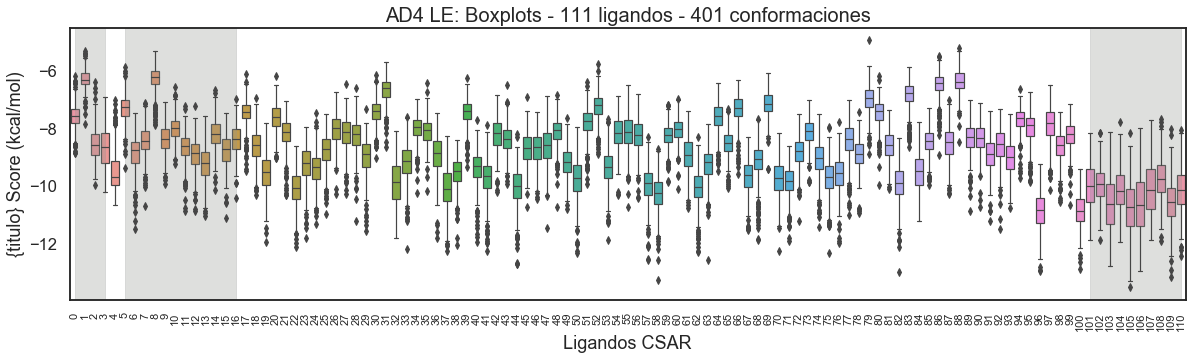

In [143]:
plot_boxplot_dock_results(df_AD4_results_LE, titulo="AD4 LE")

## Curvas ROC

In [144]:
# Librerías para calcular las ROC y el AUC
from sklearn.metrics import roc_curve, roc_auc_score

In [145]:
# Etiquetas de los lgandos, 1 = Activo
true_values = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
print(true_values)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [146]:
# Scorings PROMEDIO de Vina y Vinardo
sc_promedio_vrd = np.array(df_vinardo_results.mean(axis=1))
sc_promedio_vina = np.array(df_vina_results.mean(axis=1))
sc_promedio_ad4_LE = np.array(df_ad4_results_LE.mean(axis=1))
sc_promedio_ad4_LC = np.array(df_ad4_results_LC.mean(axis=1))

print('AUC del valor PROMEDIO (402 estructuras):')
print("AD4 LE:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LE)) )        
print("AD4 LC:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LC)) )
print("Vina:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vina)) )
print("Vinardo:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vrd)) )   

AUC del valor PROMEDIO (402 estructuras):
AD4 LE: 0.5941176470588236
AD4 LC: 0.6900452488687783
Vina: 0.5524886877828055
Vinardo: 0.7610859728506787


In [147]:
# Establecemos los parámetros para graficar
import pylab
sns.set( context = 'talk', style = 'ticks', palette = "Set2")
pylab.rcParams['figure.figsize'] = (7, 7)

def add_plot_roc(predicted_values, true_values, label):
    inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, inverted_input)
    auc = roc_auc_score( y_true = true_values, y_score = inverted_input)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 4)

def plot_roc(predicted_values, true_values, label, titulo = "ROC curve"):
    sns.color_palette("Paired")
    add_plot_roc(predicted_values, true_values, label)
    sns.set_style("white"); sns.set_context("talk")
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

SyntaxError: invalid syntax (<ipython-input-122-de603c91038f>, line 1)

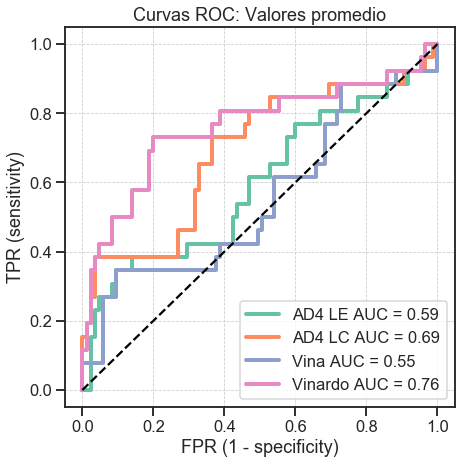

In [148]:
add_plot_roc(sc_promedio_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_promedio_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_promedio_vina, true_values, "Vina")
plot_roc(sc_promedio_vrd, true_values, "Vinardo", "Curvas ROC: Valores promedio")

In [149]:
# Scorings mínimos (mejores) de cada ligando
sc_minimo_vrd = np.array(df_vinardo_results.min(axis=1))
sc_minimo_vina = np.array(df_vina_results.min(axis=1))
sc_minimo_ad4_LE = np.array(df_ad4_results_LE.min(axis=1))
sc_minimo_ad4_LC = np.array(df_ad4_results_LC.min(axis=1))

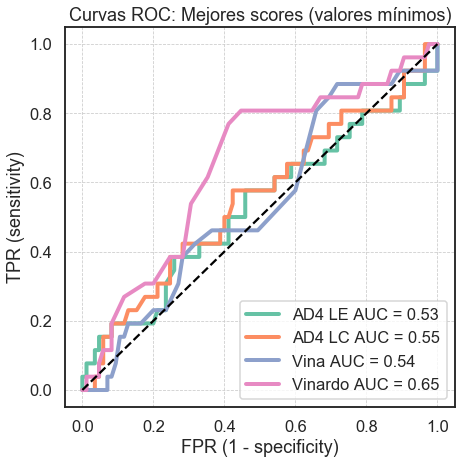

In [150]:
add_plot_roc(sc_minimo_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_minimo_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_minimo_vina, true_values, "Vina")
plot_roc(sc_minimo_vrd, true_values, "Vinardo", "Curvas ROC: Mejores scores (valores mínimos)")

In [151]:
# Caĺculo de las AUC por conformación

In [157]:
# carga del dataFrame con la información general de las estructuras cristalográficas
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")
df_cdk2_labels.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a


In [159]:
df_cdk2_labels["AUC_vrd"] = 0.0
df_cdk2_labels["AUC_vina"] = 0.0
df_cdk2_labels["AUC_ad4_LC"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vina
    roc_vrd = roc_auc_score(true_values, - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd"] = roc_vrd
    # Vinardo
    roc_vina = roc_auc_score(true_values, - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina"] = roc_vina
    # Autodock 4: LE
    roc_ad4_LE = roc_auc_score(true_values, - df_ad4_results_LE[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LE"] = roc_ad4_LE
    # Autodock 4: LC
    roc_ad4_LC = roc_auc_score(true_values, - df_ad4_results_LC[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LC"] = roc_ad4_LC

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b,0.730317,0.575339,0.634163,0.572172
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.546154,0.571946,0.483032
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.580543,0.670814,0.607919
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a,0.708145,0.535294,0.613348,0.544344
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a,0.766968,0.571493,0.764932,0.715385
